In [1]:
import pandas as pd
import numpy as np

from darts.timeseries import TimeSeries

In [2]:
features = pd.read_csv('../data/raw/features_data_set.csv')
sales = pd.read_csv('../data/raw/sales_data_set.csv')
stores = pd.read_csv('../data/raw/stores_data_set.csv')

In [3]:
sales['Date'] = pd.to_datetime(sales.Date, dayfirst=True)
sales = sales.sort_values(by=['Date'], ascending=True)

features['Date'] = pd.to_datetime(features.Date, dayfirst=True)
features = features.sort_values(by=['Date'], ascending=True)

sales['Date'] = pd.to_datetime(sales.Date, dayfirst=True)
sales = sales.sort_values(by=['Date'], ascending=True)

Solo vamos a predecir el total de ventas

In [6]:
new_dataset = sales[['Date','Weekly_Sales']].groupby('Date').agg({'Weekly_Sales':'sum'})

<Axes: xlabel='Date'>

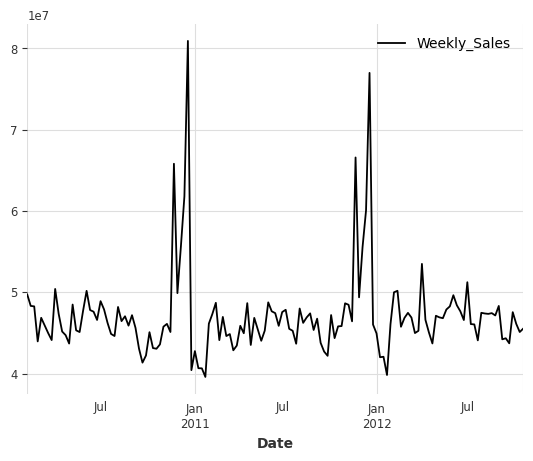

In [8]:
new_dataset.plot()

In [9]:
new_dataset = new_dataset.reset_index()

In [12]:
from typing_extensions import Annotated
from typing import Tuple

In [13]:
def train_test_split_ts(df:pd.DataFrame,
                     train_size:int=80) -> Tuple[Annotated[TimeSeries,'train'],
                                               Annotated[TimeSeries,'test']]:
    """
    Split a time series into training and testing sets.
    """
    df = TimeSeries.from_dataframe(df,
                                   time_col='Date',
                                   value_cols=['Weekly_Sales'])
    
    train, test = df.split_before(0.80)

    return train,test


In [14]:
train,test = train_test_split_ts(new_dataset)

<Axes: xlabel='Date'>

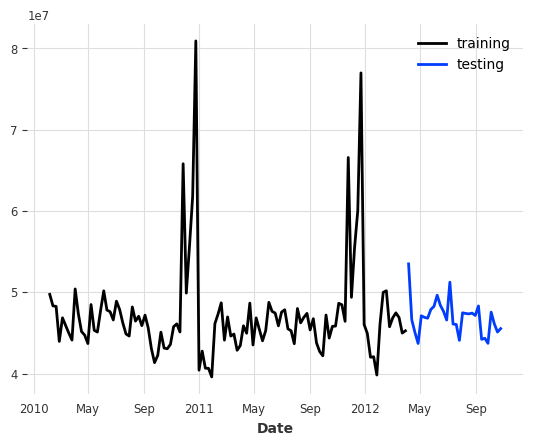

In [16]:
train.plot(label='training')
test.plot(label='testing')

Build a model

In [17]:
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
from darts.models.forecasting.auto_arima import AutoARIMA
from darts.models.forecasting.prophet_model import Prophet

In [18]:
es_model = ExponentialSmoothing()
autoarima_model = AutoARIMA()
prophet_model = Prophet()

Model Traininig

In [20]:
es_model.fit(train)
autoarima_model.fit(train)
prophet_model.fit(train)

c:\Users\PC\OneDrive\Documentos\retail_mlops_project\env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_seasonalities=None, country_holidays=None, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None)

In [27]:
es_predictions = es_model.predict(len(test))
es_predictions_ci = es_model.predict(len(test), num_samples=10)
autoarima_predictions = autoarima_model.predict(len(test))
prophet_predictions = prophet_model.predict(len(test))

<Axes: xlabel='Date'>

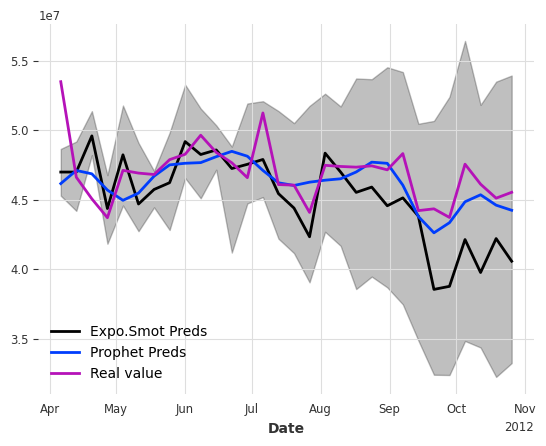

In [28]:
es_predictions_ci.plot(label='Expo.Smot Preds')
#autoarima_predictions.plot(label='AutoARIMA Preds') WORST MODEL EVER
prophet_predictions.plot(label='Prophet Preds')

test.plot(label='Real value')

<Axes: xlabel='Date'>

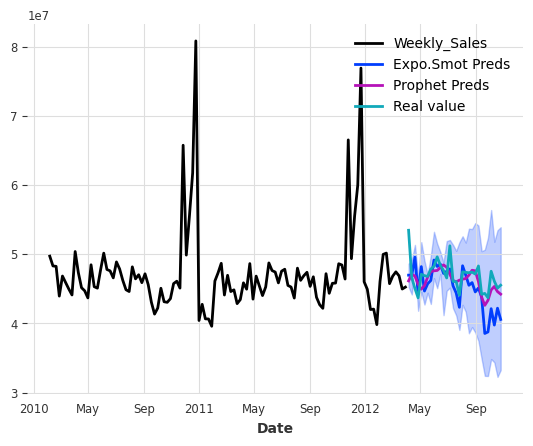

In [29]:
train.plot()
es_predictions_ci.plot(label='Expo.Smot Preds')
#autoarima_predictions.plot(label='AutoARIMA Preds') WORST MODEL EVER
prophet_predictions.plot(label='Prophet Preds')

test.plot(label='Real value')

Evaluation

In [74]:
from darts.metrics.metrics import mape

In [87]:
dataset_ts = TimeSeries.from_dataframe(new_dataset,
                                   time_col='Date',
                                   value_cols=['Weekly_Sales'])

es_historical_forecast = es_model.historical_forecasts(series=dataset_ts,
                                                    start=0.5,
                                                    retrain=True,
                                                    forecast_horizon=10,
                                                    last_points_only=False)
prophet_historical_forecast = prophet_model.historical_forecasts(series=dataset_ts,
                                                    start=0.5,
                                                    retrain=True,
                                                    forecast_horizon=10,
                                                    last_points_only=False)

`start` value `0.5` corresponding to timestamp `2011-06-17 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2012-02-03 00:00:00. To hide these warnings, set `show_warnings=False`.
c:\Users\PC\OneDrive\Documentos\retail_mlops_project\env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\OneDrive\Documentos\retail_mlops_project\env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\OneDrive\Documentos\retail_mlops_project\env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\OneDrive\Documentos\retail_mlops_project\env\Lib\s

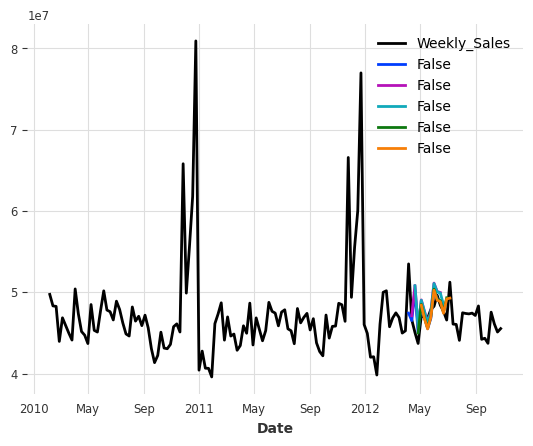

In [86]:
# Ejemplo
dataset_ts.plot()
for plot in es_historical_forecast[:5]:
    plot.plot(label=False)

In [79]:
backtesting_es = es_model.backtest(series=dataset_ts,
                                   historical_forecasts=es_historical_forecast,
                                   metric=mape,
                                   last_points_only=False,
                                   reduction=None)
backtesting_prophet = es_model.backtest(series=dataset_ts,
                                   historical_forecasts=prophet_historical_forecast,
                                   metric=mape,
                                   last_points_only=False,
                                   reduction=None)

In [81]:
print('ExponentialSmoothing Results')
print('Mean MAPE %:')
print(np.mean(backtesting_es))

print('Last MAPE %:')
print(backtesting_es[-1])
print('---------------------------')
print('---------------------------')
print('Prophet Model Results')
print('Mean MAPE %:')
print(np.mean(backtesting_prophet))
print('Last MAPE %:')
print(backtesting_prophet[-1])


ExponentialSmoothing Results
Mean MAPE %:
2.7766773821477972
Last MAPE %:
1.7852560696930335
---------------------------
---------------------------
Prophet Model Results
Mean MAPE %:
5.3917316653402745
Last MAPE %:
2.0184934514069197
